### 3_Black-Litterman Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
stock = pd.read_table('019/stock.txt',sep='\t',index_col = 'Trddt')
stock.index = pd.to_datetime(stock.index)  #把索引的类型转变为datetime

In [3]:
fjgs = stock[stock.Stkcd==600033]['Dretwd']
fjgs.name = 'fjgs'
zndl = stock[stock.Stkcd==600023]['Dretwd']
zndl.name = 'zndl'
sykj = stock[stock.Stkcd==600183]['Dretwd']
sykj.name = 'sykj'
hxyh = stock[stock.Stkcd==600015]['Dretwd']
hxyh.name = 'hxyh'
byjc = stock[stock.Stkcd==600004]['Dretwd']
byjc.name = 'byjc'

In [4]:
returns = pd.concat([byjc,fjgs,hxyh,sykj,zndl],axis=1)
returns.head()

,byjc,fjgs,hxyh,sykj,zndl
Trddt,,,,,
2014-01-02,-0.001439,0.000000,-0.031505,0.002024,0.008876
2014-01-03,-0.008646,0.004673,-0.028916,-0.012121,-0.013196
2014-01-06,-0.018895,-0.023256,-0.023573,-0.026585,0.005944
2014-01-07,-0.007407,0.004762,-0.003812,0.021008,-0.013294
2014-01-08,0.005970,-0.014218,0.021684,-0.014403,0.008982


延续Markowitz模型的5只股票资产分配的例子,在这里加上投资者的个人观点进行分析.     
假设白云机场,华夏银行,浙能电力,生益科技四支股票的日均收益达到0.3%    
两支交通类股票白云机场和福建高速的日均收益将比浙能动力高0.1%.以此为根据构建个人观点.

In [5]:
pick1 = np.array([1,0,1,1,1])
q1 = np.array([0.003*4])
pick2 = np.array([0.5,0.5,0,0,-1])
q2 = np.array([0.001])
P = np.array([pick1,pick2])
Q = np.array([q1,q2])

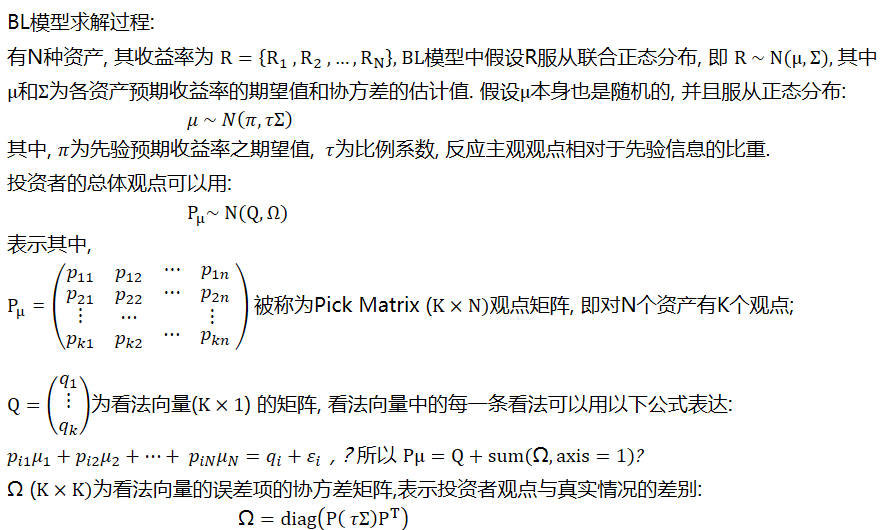

Pick Matrix, K*N的矩阵,N个资产有K个观点

In [6]:
P

array([[ 1. ,  0. ,  1. ,  1. ,  1. ],
       [ 0.5,  0.5,  0. ,  0. , -1. ]])

Q为看法向量(2*1列向量)

In [7]:
Q

array([[0.012],
       [0.001]])

In [8]:
def blacklittermans(returns,tau,P,Q):
    mu = returns.mean()
    sigma = returns.cov()
    pi1 = mu
    ts = tau * sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    BLCov = linalg.inv(linalg.inv(ts) + np.dot(P.T,np.dot(linalg.inv(Omega),P)))
    BLmu = np.dot(BLCov,np.dot(linalg.inv(ts),pi1).reshape(-1,1)+np.dot(P.T,np.dot(linalg.inv(Omega),Q)).reshape(-1,1))
    posteriorSigma = sigma + BLCov
    return [BLmu,posteriorSigma]

In [9]:
res = blacklittermans(returns,0.1,P,Q)

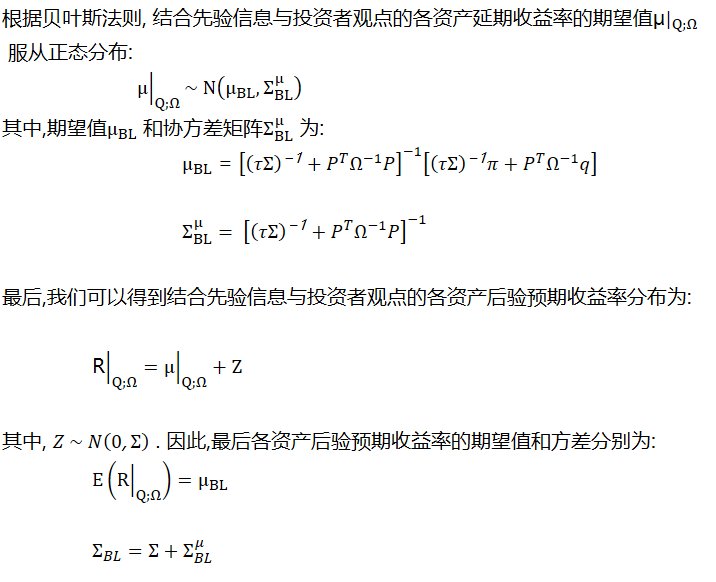

In [14]:
p_mean = pd.DataFrame(res[0],index=returns.columns, columns=['posterior_mean'])
p_mean

,posterior_mean
byjc,0.002857
fjgs,0.003931
hxyh,0.002629
sykj,0.002921
zndl,0.002337


In [16]:
p_cov = res[1]
p_cov

,byjc,fjgs,hxyh,sykj,zndl
byjc,0.000353,0.000246,0.000134,0.000132,0.000180
fjgs,0.000246,0.000506,0.000138,0.000155,0.000201
hxyh,0.000134,0.000138,0.000515,0.000085,0.000179
sykj,0.000132,0.000155,0.000085,0.000385,0.000127
zndl,0.000180,0.000201,0.000179,0.000127,0.000494


得到了后验收益的期望值和协方差矩阵后,就可以利用Markowitz模型进行资产的配置,

In [19]:
def BLminVar(BLres,goalRet):
        covs = np.array(BLres[1])
        means = np.array(BLres[0])
        means = means.reshape(-1,1)
        ones = np.ones((len(means),1))
        
        L1 = np.hstack((covs,means,ones)) 
        L2 = np.ones((1,len(means)))
        L2 = np.append(L2,[0,0])
        L3 = means.T
        L3 = np.append(L3,[0,0])
        L = np.vstack((L1,L2,L3))
        
        y = np.zeros((len(means),1))
        y = np.append(y,[1,goalRet])
       
        results=linalg.solve(L,y)
        return (pd.DataFrame(results[:-2],index=BLres[1].columns,columns=['p_weight'])) 

将前面加入投资人观点的资产后验分布结果res及投资人目标收益率(年收益率为75%)作为goalRet传入函数BLminVar(),可得最优资产配置比

In [20]:
BLminVar(res,0.75/252)

,p_weight
byjc,0.226360
fjgs,0.172357
hxyh,0.201557
sykj,0.321434
zndl,0.078292
